<a href="https://colab.research.google.com/github/teamgaon/KIST/blob/main/%5BAnalytics%5D_%EA%B0%80%EC%98%A8%2C_%ED%86%B5%EA%B3%84%EB%B6%84%EC%84%9D%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%83%9D%EC%9C%A1%EC%A0%95%EB%8F%84_%EC%B6%94%EC%A0%95_%EC%A0%95%EB%9F%89_%EC%A7%80%ED%91%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **생육 환경 최적화 경진대회**
### 적상추 데이터 활용 생육정도를 알 수 있는 정량 지표 발굴

# **목차**  

##   **1. 서론** 
- #### 1.1 목표정의

##   **2. 데이터 전처리**
- #### 2.1 target   
- #### 2.2 데이터 병합  

##   **3. Feature Selection**
- #### 3.1 Target과 Feature의 상관관계  
  - ##### Model 1
    - ##### Train & Test 데이터 셋 분리  
    - ##### 모델링  
- #### 3.2 Stepwise Feature Selection  
  - ##### Model 2
    - ##### Train & Test 데이터 셋 분리  
    - ##### 모델링  
- #### 3.3 feature간 상관관계  
  - ##### Model 3
    - ##### Train & Test 데이터 셋 분리  
    - ##### 모델링 

##   **4. 결론** 
- #### 4.1 예측 결과  
- #### 4.2 결과 해석  


# 1. 서론

## 1.1 목표 정의

- 적상추 데이터 활용 **생육정도**를 알 수 있는 **정량 지표 발굴**  

적상추 데이터에는 날짜 값을 포함한 여러 생육데이터 측정값이 있습니다.  
저희 과제의 목표는 적상추 데이터를 활용하여 적상추의 생육 정도를 알 수 있는 정량 지표를 발굴 하는 것입니다.
 
각 데이터를 측정한 날짜를 통해 0~100%로 수치화한것을 target으로 정하여,  
target인 생육정도와 상관관계가 높은 feature를 추출하여 생육 정도를 알 수 있는 정량지표를 발굴 할 수 있을 것입니다.

In [173]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv]
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
fc-cache: invalid option -- ']'
usage: fc-cache [-EfrsvVh] [-y SYSROOT] [--error-on-no-fonts] [--force|--really-force] [--sysroot=SYSROOT] [--system-only] [--verbose] [--version] [--help] [dirs]
Build font information caches in [dirs]
(all directories in font configuration by default).

  -E, --error-on-no-fonts  raise an error if no fonts in a directory
  -f, --force              scan directories with apparently valid caches
  -r, --really-force       erase all existing caches, then rescan
  -s, --system-only        scan system-wide directories only
  -y, --sysroot=SYSROOT    prepend SYSROOT to all paths fo

In [250]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import cv2

In [16]:
train = glob('/content/drive/MyDrive/KIST/red_lettuce/*/*.xlsx')
train.sort()

# 2. 데이터 전처리

- 사용 데이터

red_lettuce 폴더의 모든 CASE


데이콘에서 제공된 데이터는 적상추의 **생육과정을 촬영한 이미지**와 1분 간격으로 측정된 **환경데이터**입니다.  

이미지를 살펴보면 적상추의 생육과정이 시간 순서대로 담겨있습니다.  

저희는 이를 토대로 시간 순으로 측정된 환경데이터를 **일 단위로 병합**하여, 해당 **인덱스를 target으로 설정**하였습니다.  
(ex. 30일 동안 측정된 적상추라면 상추가 생육과정이 시작될 때를 0, 생육과정이 끝났을 때를 30으로 구분)

그 후 분석에 **불필요한 feature를 제거**하고, **스케일링**하여 모델링에 사용할 데이터프레임을 구성했습니다.

- 모델링을 위해 사용한 환경 데이터는 특이값이 있다 하더라도 이상치가 아니라고 판단했기 때문에 RobustScaler와 MinMaxScaler를 비교해 보았을 때, MinMaxScaler가 모델 성능을 더 향상시킨다고 판단하여 이를 사용했습니다.  

**최종적으로 target은 성장이 얼만큼 진행되었는지 백분율로 나타나게 됩니다.**  
(ex. 30일 중 15일이라면 50%) 

## 2.1 Target

In [175]:
!unzip /content/drive/MyDrive/KIST/red_lettuce/CASE1/image_20210416.zip

Archive:  /content/drive/MyDrive/KIST/red_lettuce/CASE1/image_20210416.zip
replace 1618595172032.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 1618595172032.png       
  inflating: 1618681570276.png       
  inflating: 1618767971443.png       
  inflating: 1618854370789.png       
  inflating: 1618940770769.png       
  inflating: 1619027170527.png       
  inflating: 1619113570817.png       
  inflating: 1619199970164.png       
  inflating: 1619286370321.png       
  inflating: 1619372770641.png       
  inflating: 1619459170599.png       
  inflating: 1619545571221.png       
  inflating: 1619631970610.png       
  inflating: 1619718370226.png       
  inflating: 1619804786281.png       
  inflating: 1619891172056.png       
  inflating: 1619977571243.png       
  inflating: 1620063989084.png       
  inflating: 1620150370998.png       
  inflating: 1620236770695.png       
  inflating: 1620323170676.png       
  inflating: 1620409571019.png       
  inflating: 162075517

target : 0.%


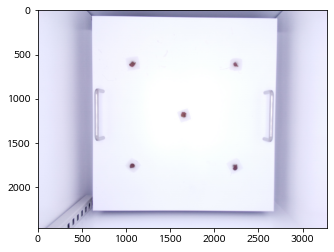

target : 10%


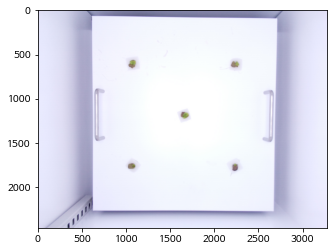

target : 20%


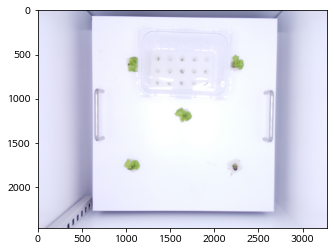

target : 30%


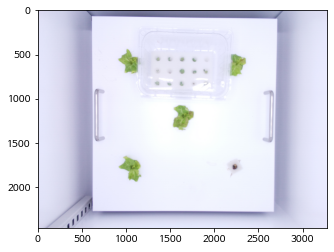

target : 40%


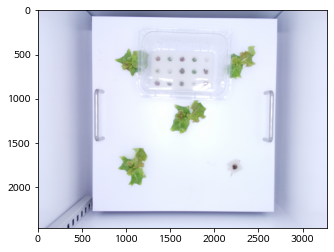

target : 50%


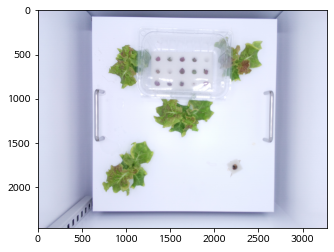

target : 60%


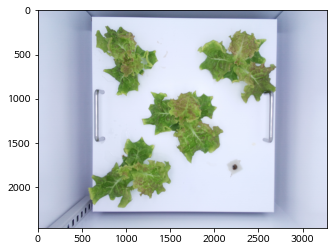

target : 70%


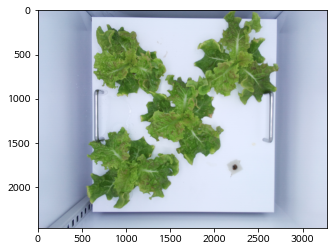

target : 80%


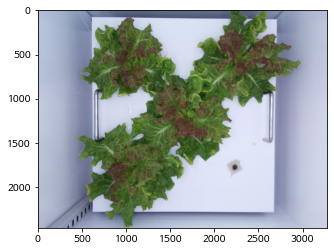

target : 90%


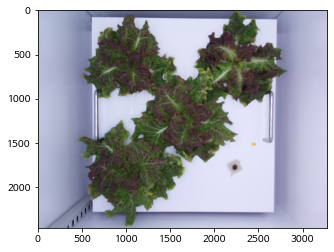

In [253]:
images = glob('/content/*.png')
images.sort()
label = df['target']
for i in range(10):
  idx = i*0.1
  image = cv2.imread(images[int(len(images)*idx)])
  print('target : ' + str(idx*100)[:2] + '%')
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

이미지 데이터를 보았을 때 적상추의 생육 과정이 시간 순으로 나열된 것을 알 수 있습니다.  
각 CASE 내의 이미지와 환경 데이터는 동일한 측정 기간을 갖고 있으므로,  환경데이터를 일별로 병합한 인덱스를 target으로 지정했습니다.

## 2.2 데이터 병합

In [255]:
# CASE1
temp = pd.read_excel(train[0])
temp.head(3)

,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,...,냉방온도,난방온도,기준온도,내외부온도차,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
0,2021-04-16 00:00,26.9,35.200001,471.0,0.277890,16.100000,46.500000,NaN,NaN,0.0,...,16.0,14.0,15.0,NaN,0.0,54.499998,0.0,0.0,0.0,0.0
1,2021-04-16 00:01,26.9,35.200001,471.0,0.277890,16.100000,46.500000,0.0,0.0,0.0,...,16.0,14.0,15.0,10.799999,0.0,54.499998,0.0,0.0,0.0,0.0
2,2021-04-16 00:02,26.9,35.200001,465.0,0.278563,16.299999,46.400002,0.0,0.0,0.0,...,16.0,14.0,15.0,NaN,0.0,54.499998,0.0,0.0,0.0,0.0


In [256]:
# 시간 칼럼을 통해 년월일 칼럼 생성
temp['시간'] = pd.to_datetime(temp['시간'])
temp['년월일'] = temp['시간'].dt.year.astype(str) + '-' + temp['시간'].dt.month.astype(str) + '-' + temp['시간'].dt.day.astype(str)
temp['년월일'] = pd.to_datetime(temp['년월일'])

# 날짜를 기준으로 그룹화
temp_mean = temp.groupby('년월일').mean()

# 인덱스를 타겟으로 설정
temp_mean = temp_mean.reset_index(drop=True)
temp_mean['target'] = temp_mean.index

# 스케일링
scaler = MinMaxScaler()
scaler.fit(temp_mean)
df = scaler.transform(temp_mean)
df = pd.DataFrame(df, columns=temp_mean.columns)

# 결측치 제거
df.dropna(inplace=True)
df.head()

,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,...,난방온도,기준온도,내외부온도차,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,target
0,0.324143,0.076318,0.296703,0.342547,0.000000,0.483444,0.835547,0.819760,0.896177,0.717680,...,0.000000,0.000000,0.901651,0.85711,0.395318,0.852921,0.858656,0.872264,0.801542,0.000000
1,0.512063,0.017478,0.198588,0.571200,0.188076,0.241492,0.804498,0.773329,0.873003,0.792618,...,0.993834,0.993616,0.975879,0.00000,0.466369,0.998933,0.999305,0.996561,0.997229,0.025641
2,0.470331,0.000000,0.106364,0.602955,0.122473,0.167146,0.744000,0.728249,0.906268,0.715531,...,0.994312,0.994109,0.988041,0.00000,0.420781,0.998800,0.998931,0.997975,0.997856,0.051282
3,0.460843,0.043290,0.232362,0.608868,0.099904,0.217909,0.807292,0.789540,0.883998,0.767761,...,0.993881,0.993606,1.000000,0.00000,0.410280,0.998091,0.998184,0.998728,0.996550,0.076923
4,0.602986,0.124564,0.419970,0.608833,0.309992,0.188386,0.930000,0.898267,0.930131,0.883952,...,0.994215,0.993991,0.975676,0.00000,0.565850,0.999099,0.999454,0.997033,0.997334,0.102564


In [257]:
# CASE2 - CASE10 전처리 후, CASE1과 병합
for i in tqdm(range(1,len(train))):
  temp = pd.read_excel(train[i])
  temp.dropna(subset=['시간'],inplace=True)
  temp['시간'] = pd.to_datetime(temp['시간'])
  temp['년월일'] = temp['시간'].dt.year.astype(str) + '-' + temp['시간'].dt.month.astype(str) + '-' + temp['시간'].dt.day.astype(str)
  print(i)
  temp['년월일'] = pd.to_datetime(temp['년월일'])
  temp_mean = temp.groupby('년월일').mean()

  temp_mean = temp_mean.reset_index(drop=True)
  temp_mean['target'] = temp_mean.index


  scaler = MinMaxScaler()
  scaler.fit(temp_mean)

  df_sam = scaler.transform(temp_mean)
  df_sam = pd.DataFrame(df_sam, columns=temp_mean.columns)
  df_sam.dropna(inplace=True)
  df = pd.concat([df, df_sam])

df = df.reset_index(drop=True)
df.head()

 11%|█         | 1/9 [00:19<02:35, 19.48s/it]

1


 22%|██▏       | 2/9 [00:38<02:16, 19.45s/it]

2


 33%|███▎      | 3/9 [00:58<01:55, 19.31s/it]

3


 44%|████▍     | 4/9 [01:17<01:37, 19.45s/it]

4


 56%|█████▌    | 5/9 [01:36<01:17, 19.33s/it]

5


 67%|██████▋   | 6/9 [01:56<00:58, 19.36s/it]

6


 78%|███████▊  | 7/9 [02:15<00:38, 19.28s/it]

7


 89%|████████▉ | 8/9 [02:34<00:19, 19.33s/it]

8


100%|██████████| 9/9 [02:48<00:00, 18.75s/it]

9


,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,...,난방온도,기준온도,내외부온도차,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,target
0,0.324143,0.076318,0.296703,0.342547,0.000000,0.483444,0.835547,0.819760,0.896177,0.717680,...,0.000000,0.000000,0.901651,0.85711,0.395318,0.852921,0.858656,0.872264,0.801542,0.000000
1,0.512063,0.017478,0.198588,0.571200,0.188076,0.241492,0.804498,0.773329,0.873003,0.792618,...,0.993834,0.993616,0.975879,0.00000,0.466369,0.998933,0.999305,0.996561,0.997229,0.025641
2,0.470331,0.000000,0.106364,0.602955,0.122473,0.167146,0.744000,0.728249,0.906268,0.715531,...,0.994312,0.994109,0.988041,0.00000,0.420781,0.998800,0.998931,0.997975,0.997856,0.051282
3,0.460843,0.043290,0.232362,0.608868,0.099904,0.217909,0.807292,0.789540,0.883998,0.767761,...,0.993881,0.993606,1.000000,0.00000,0.410280,0.998091,0.998184,0.998728,0.996550,0.076923
4,0.602986,0.124564,0.419970,0.608833,0.309992,0.188386,0.930000,0.898267,0.930131,0.883952,...,0.994215,0.993991,0.975676,0.00000,0.565850,0.999099,0.999454,0.997033,0.997334,0.102564


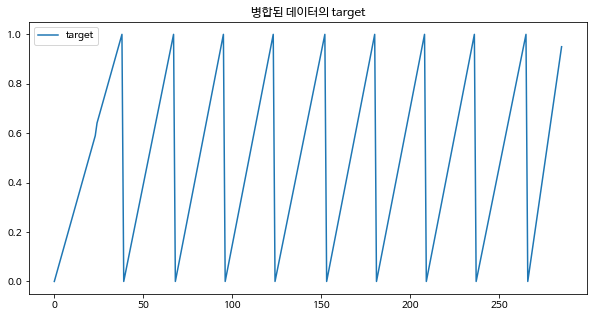

In [258]:
df[['target']].plot(figsize=(10,5))
plt.title('병합된 데이터의 target')
plt.show()

# 3. Feature Selection

## 3.1 Target과 Feature의 상관관계

target에 유의미한 feature를 선별하기 위하여 상관관계를 확인해볼 것입니다.

In [259]:
df_corr = df.corr()['target']
df_corr = pd.DataFrame(df_corr.sort_values(ascending=False), columns=['target'])
df_corr.style.background_gradient(cmap='viridis')

,target
target,1.000000
외부환기팬작동남은시간,0.756017
외부환기팬상태,0.736303
레드 LED동작강도,0.660548
블루 LED동작강도,0.649316
청색광추정광량,0.645829
적색광추정광량,0.645604
내부습도관측치,0.570866
난방부하,0.371632
외부습도관측치,0.268429


상관계수가 0.3미만으로 나타난  

**'외부습도관측치', '난방작동남은시간', '펌프상태', '내부유동팬작동남은시간', '난방상태', '블루 LED작동남은시간', '일간누적분무량', 'EC관측치', '레드 LED작동남은시간', '화이트 LED작동남은시간', '펌프작동남은시간', '내부유동팬상태', '화이트 LED상태', '레드 LED상태', '블루 LED상태', '카메라상태', '난방온도', '냉방온도','기준온도', '외부온도관측치', 'CO2관측치'**  

는 상관관계가 없다고 판단하여 모델의 feature에서 제거하였습니다.

In [260]:
df_corr[abs(df_corr['target'])>=0.3].index

Index(['target', '외부환기팬작동남은시간', '외부환기팬상태', '레드 LED동작강도', '블루 LED동작강도',
       '청색광추정광량', '적색광추정광량', '내부습도관측치', '난방부하', '최근분무량', '냉방부하', '냉방작동남은시간',
       '내부온도관측치', '내외부온도차', '냉방상태', '총추정광량', '백색광추정광량', '화이트 LED동작강도'],
      dtype='object')

In [261]:
feature = ['target', '외부환기팬작동남은시간', '외부환기팬상태', '레드 LED동작강도', '블루 LED동작강도',
       '청색광추정광량', '적색광추정광량', '내부습도관측치', '난방부하', '최근분무량', '냉방부하', '냉방작동남은시간',
       '내부온도관측치', '내외부온도차', '냉방상태', '총추정광량', '백색광추정광량', '화이트 LED동작강도']
df = df[feature]
df.head()

,target,외부환기팬작동남은시간,외부환기팬상태,레드 LED동작강도,블루 LED동작강도,청색광추정광량,적색광추정광량,내부습도관측치,난방부하,최근분무량,냉방부하,냉방작동남은시간,내부온도관측치,내외부온도차,냉방상태,총추정광량,백색광추정광량,화이트 LED동작강도
0,0.000000,0.0,0.0,0.870670,0.797762,0.801542,0.872264,0.076318,0.85711,0.896177,0.395318,0.591989,0.324143,0.901651,0.673469,0.852921,0.858656,0.855791
1,0.025641,0.0,0.0,0.992256,0.990416,0.997229,0.996561,0.017478,0.00000,0.873003,0.466369,0.922968,0.512063,0.975879,0.997161,0.998933,0.999305,0.996414
2,0.051282,0.0,0.0,0.994194,0.993682,0.997856,0.997975,0.000000,0.00000,0.906268,0.420781,0.914306,0.470331,0.988041,0.997183,0.998800,0.998931,0.997117
3,0.076923,0.0,0.0,0.994292,0.987036,0.996550,0.998728,0.043290,0.00000,0.883998,0.410280,0.933100,0.460843,1.000000,1.000000,0.998091,0.998184,0.993211
4,0.102564,0.0,0.0,0.992870,0.992235,0.997334,0.997033,0.124564,0.00000,0.930131,0.565850,0.929445,0.602986,0.975676,0.988725,0.999099,0.999454,0.996371


### Model 1

- **다중선형회귀분석(Multiple Linear Regression)**  

회귀분석은 반응변수에 대한 설명변수의 영향력을 예측하는
방법으로 반응변수 변화의 원인을 설명변수로 해석이 가능하다.  

설명변수와 반응변수의 관계를 선형적이라 가정한 경우
선형회귀분석이라 하며 이 선형적 관계는 예측 모델을 가장
단순하게 만들고 표본데이터에 의한 과적합을 줄일 수 있다.  
 
실제 산업 현장에서
선형회귀분석이 가장 많이 쓰이고 있으며 실제 데이터는 설명
변수 하나만으로 회귀분석을 할 수 있는 경우는 매우 드물기
때문에 다수의 설명변수를 활용한 다중선형회귀분석이 주로
사용된다.

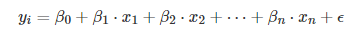  

다중선형회귀모형을 일반화하면 위 식과 같으며 여기서 Y
는 반응변수, X는 설명변수, β는 선형회귀계수, ε는 오차이다.

이때 ε는 기댓값은 0이고 분산이 일정한 정규분포를 따른다고
가정한다.

선형회귀분석의 회귀 계수를 추정하기 위해서 대표적으로 최소제곱법(ordinary least square; OLS)을 사용하며 다음과 같이 오차 제곱합을 최소화하는 회귀 계수를 추정하게 된다.


#### Train & Test 데이터 셋 분리

- df_y : 예측할 target

- df_x : 상관관계 분석을 통해 선별된 feature가 포함된 데이터 셋

In [262]:
df_y = df['target']
df_x = df.drop(columns = ['target'])

# train data:test data = 8:2
# 동일 데이터 활용을 위해 random_state=0 고정
X_train, X_test, y_train, y_test = train_test_split(df_x,df_y,test_size=0.2,random_state=0)

# 상수항 추가
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(228, 18) (58, 18) (228,) (58,)


#### 모델링

In [263]:
model1 = sm.OLS(y_train,X_train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     62.20
Date:                Mon, 16 May 2022   Prob (F-statistic):           3.85e-72
Time:                        08:42:49   Log-Likelihood:                 158.45
No. Observations:                 228   AIC:                            -280.9
Df Residuals:                     210   BIC:                            -219.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3020      0.066      4.573      0.000       0.172       0.432
외부환기팬작동남은시간     1.4826      0.318      4.669      0.000       0.857       2.108
외부환기팬상태        -1.1099      0.319     -3.483      0.001      -1.738      -0.482
레드 LED동작강도      0.2427      0.132      1.842      0.067      -0.017       0.502
블루 LED동작강도      0.1913      0.246      0.777      0.438      -0.294       0.676
청색광추정광량         0.7056      0.956      0.738      0.461      -1.178       2.590
적색광추정광량        -0.8946      1.004     -0.891      0.374      -2.874       1.085
내부습도관측치         0.2075      0.045      4.646      0.000       0.119       0.296
난방부하           -0.0103      0.045     -0.231      0.818      -0.099       0.078
최근분무량          -0.0478      0.035     -1.379      0.169      -0.116       0.021
냉방부하           -0.0851      0.129     -0.658      0.511      -0.340       0.170
냉방작동남은시간       -0.0817      0.061     -1.340      0.182      -0.202       0.038
내부온도관측치        -0.1523      0.128     -1.187      0.237      -0.405       0.101
내외부온도차         -0.1311      0.040     -3.245      0.001      -0.211      -0.051
냉방상태            0.0865      0.077      1.122      0.263      -0.065       0.238
총추정광량          -0.3341      0.149     -2.235      0.026      -0.629      -0.039
백색광추정광량         0.5062      0.182      2.779      0.006       0.147       0.865
화이트 LED동작강도    -0.1971      0.066     -3.008      0.003      -0.326      -0.068
==============================================================================
Omnibus:                       17.624   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.703
Skew:                           0.442   Prob(JB):                     3.55e-07
Kurtosis:                       4.532   Cond. No.                         402.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- R-squred , Adj.R-squred : 0.834, 0.821  
주어진 데이터를 현재 모형이 얼마나 잘 설명하고 있는지를 나타내는 지수이며, 설명력이 높다고 해석할 수 있습니다.  

- Prob(F-statistics) : 3.85e-72  
현재 모형에 대한 p-value로 보통 0.05인 경우 통계적으로 유의미하다고 판단됩니다.  
따라서 현재 모형은 통계적으로 유의미하다고 볼 수 있습니다.  

- 각 변수들의 p-value  
p값이 높은 변수들이 많은 것을 확인할 수 있습니다.  
이는 해당 변수들이 통계적으로 유의미하다고 볼 수 없습니다.

유의미한 변수만 선별하여 분석에 활용하기 위해 **단계선택법**을 수행하고,  
**다중공선성**을 고려한 변수 선택 과정을 수행할 것입니다.


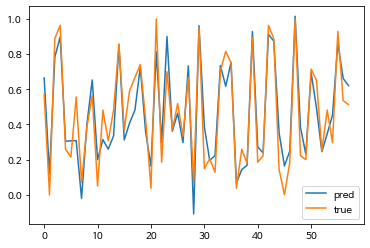

0.09184365925903935


In [264]:
# 테스트 셋 예측
y_pred = model1.predict(X_test)

plt.plot(np.array(y_pred),label = "pred")
plt.plot(np.array(y_test),label = "true")
plt.legend()
plt.show()

# mae
print(mean_absolute_error(y_test, y_pred))

상관관계 분석만을 수행하여 변수를 선택한 1차 모델링 결과  
mae는 9.18%인 것을 확인할 수 있습니다.

하지만 앞서 언급한 것 처럼 다중공선성 등의 문제로 해당 모델이 신뢰성있는 결과가 도출된다고 확신할 수 없으므로,  
이후의 feature 선별 과정을 거친 후 mae가 개선될 것으로 기대된다.

## 3.2 Stepwise Feature Selection

- **단계선택법(Stepwise Feature Selection)**  

전진선택법에 의해 변수를 추가하면서 새롭게 추가된 변수에 기인해 기존 변수의 중요도가 약화되면 해당변수를 제거하는 등,  
단계별로 추가 또는 제거되는 변수의 여부를 검토해 회귀식을 적합하는 방식

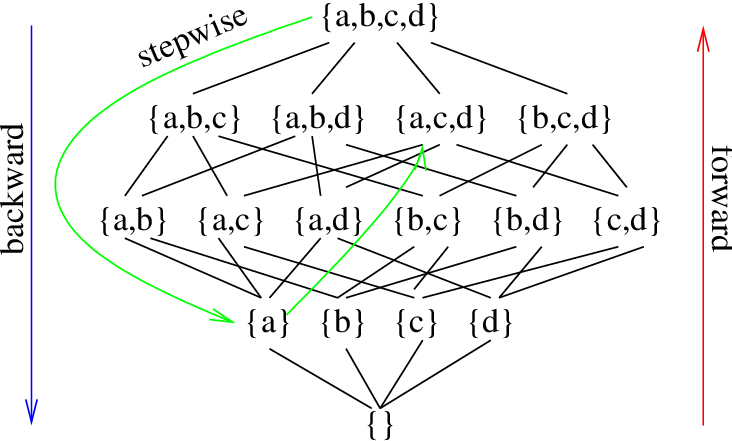

앞서 상관관계 분석을 통해 선별된 feature로 단계선택법 수행

In [265]:
df_x.head()

,외부환기팬작동남은시간,외부환기팬상태,레드 LED동작강도,블루 LED동작강도,청색광추정광량,적색광추정광량,내부습도관측치,난방부하,최근분무량,냉방부하,냉방작동남은시간,내부온도관측치,내외부온도차,냉방상태,총추정광량,백색광추정광량,화이트 LED동작강도
0,0.0,0.0,0.870670,0.797762,0.801542,0.872264,0.076318,0.85711,0.896177,0.395318,0.591989,0.324143,0.901651,0.673469,0.852921,0.858656,0.855791
1,0.0,0.0,0.992256,0.990416,0.997229,0.996561,0.017478,0.00000,0.873003,0.466369,0.922968,0.512063,0.975879,0.997161,0.998933,0.999305,0.996414
2,0.0,0.0,0.994194,0.993682,0.997856,0.997975,0.000000,0.00000,0.906268,0.420781,0.914306,0.470331,0.988041,0.997183,0.998800,0.998931,0.997117
3,0.0,0.0,0.994292,0.987036,0.996550,0.998728,0.043290,0.00000,0.883998,0.410280,0.933100,0.460843,1.000000,1.000000,0.998091,0.998184,0.993211
4,0.0,0.0,0.992870,0.992235,0.997334,0.997033,0.124564,0.00000,0.930131,0.565850,0.929445,0.602986,0.975676,0.988725,0.999099,0.999454,0.996371


In [266]:
# train data:test data =  8:2
X_train, X_test, y_train, y_test = train_test_split(df_x,df_y,test_size=0.2,random_state=0)

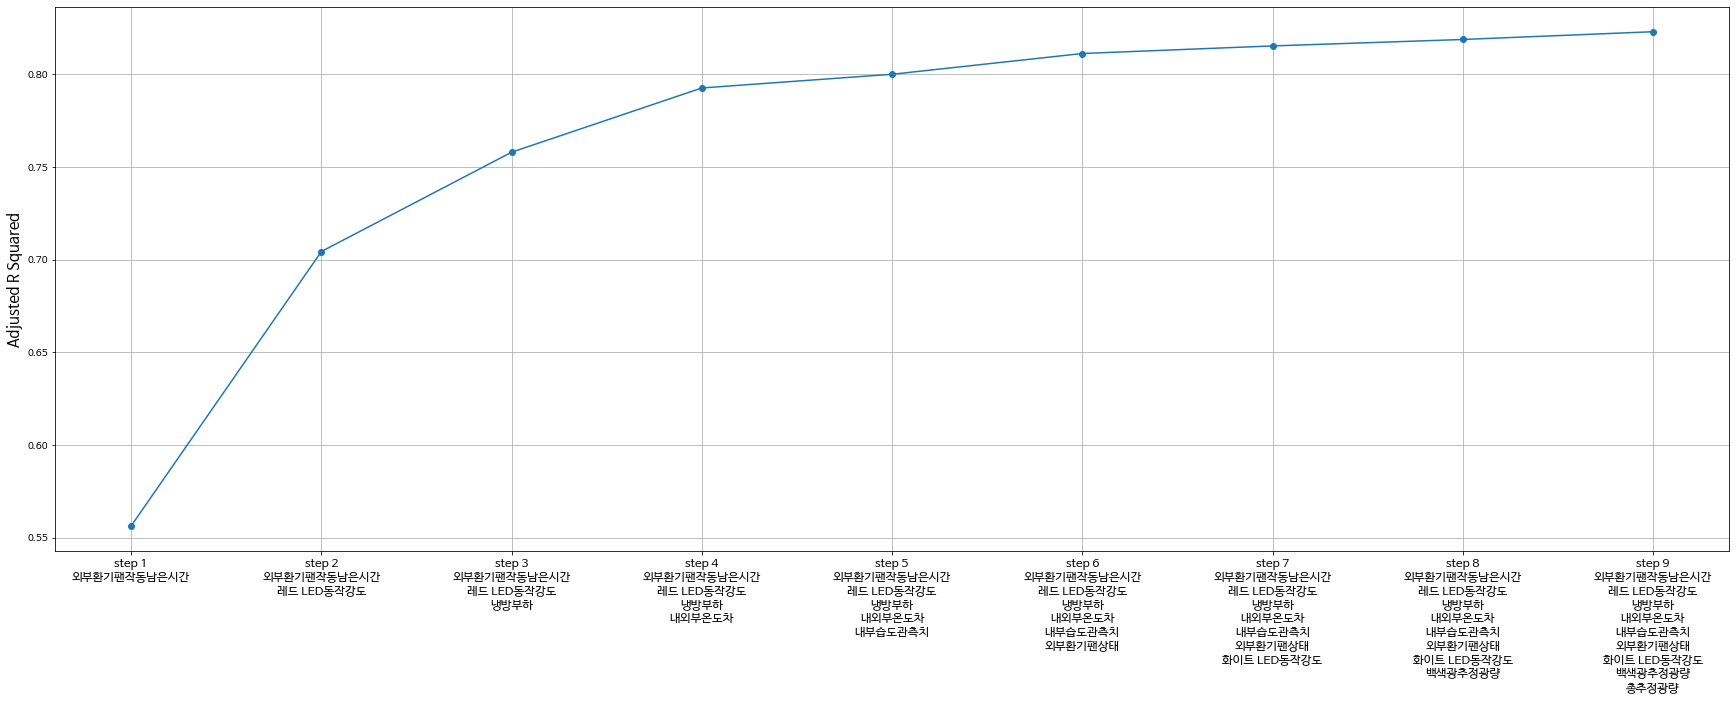

In [267]:
def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ):
  # 반응변수
  y = y_train
  # 선택된 변수들
  selected_variables = []
  sl_enter = 0.05 
  sl_remove = 0.05 
  
  # 각 스텝별로 선택된 변수들
  sv_per_step = []
  # 각 스텝별 수정된 결정계수 
  adjusted_r_squared = []
  steps = []
  step = 0 
  while len(variables) > 0: 
    remainder = list(set(variables) - set(selected_variables))
    # 변수의 p-value 
    pval = pd.Series(index=remainder)
    # 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 선형 모형을 적합
    for col in remainder:
      X = X_train[selected_variables+[col]] 
      X = sm.add_constant(X) 
      model = sm.OLS(y,X).fit(disp=0) 
      pval[col] = model.pvalues[col] 
      min_pval = pval.min() 

    # 최소 p-value 값이 기준 값보다 작으면 포함   
    if min_pval < sl_enter:
      selected_variables.append(pval.idxmin()) 
        # 선별된 변수들에 대해 어떤 변수를 제거할 지 선택
      while len(selected_variables) > 0:
        selected_X = X_train[selected_variables] 
        selected_X = sm.add_constant(selected_X) 
        selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] 
          # 절편항의 p-value는 제외
        max_pval = selected_pval.max() 
        # 최대 p-value값이 기준값보다 크거나 같으면 제외 
        if max_pval >= sl_remove:
          remove_variable = selected_pval.idxmax() 
          selected_variables.remove(remove_variable) 
        else: 
          break 
      step += 1
      steps.append(step) 
      adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj 
      adjusted_r_squared.append(adj_r_squared) 
      sv_per_step.append(selected_variables.copy()) 
    else: 
      break 
  fig = plt.figure(figsize=(30,10)) 
  fig.set_facecolor('white') 
  
  font_size = 15 
  plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12) 
  plt.plot(steps,adjusted_r_squared, marker='o') 
  plt.ylabel('Adjusted R Squared',fontsize=font_size) 
  plt.grid(True) 
  plt.show() 
  
  return selected_variables 
  
selected_variables = stepwise_feature_selection(X_train, y_train)

단계선택법을 통해 선별된 feature

In [268]:
selected_variables

['외부환기팬작동남은시간',
 '레드 LED동작강도',
 '냉방부하',
 '내외부온도차',
 '내부습도관측치',
 '외부환기팬상태',
 '화이트 LED동작강도',
 '백색광추정광량',
 '총추정광량']

### Model 2

#### Train & Test 데이터 셋 분리

- step_y : 예측할 target

- step_x : 단계선택법을 통해 선별된 feature가 포함된 데이터 셋

In [269]:
step_y = df['target']
step_x = df[selected_variables]

# train data:test data = 8:2
# 동일 데이터 활용을 위해 random_state=0 고정
X_train, X_test, y_train, y_test = train_test_split(step_x,step_y,test_size=0.2,random_state=0)

# 상수항 추가
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(228, 10) (58, 10) (228,) (58,)


#### 모델링

In [270]:
model2 = sm.OLS(y_train,X_train).fit(disp=0)
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     118.3
Date:                Mon, 16 May 2022   Prob (F-statistic):           8.08e-79
Time:                        08:42:50   Log-Likelihood:                 155.60
No. Observations:                 228   AIC:                            -291.2
Df Residuals:                     218   BIC:                            -256.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2946      0.055      5.367      0.000       0.186       0.403
외부환기팬작동남은시간     1.5927      0.307      5.184      0.000       0.987       2.198
레드 LED동작강도      0.2216      0.025      8.701      0.000       0.171       0.272
냉방부하           -0.2082      0.031     -6.655      0.000      -0.270      -0.147
내외부온도차         -0.1490      0.036     -4.159      0.000      -0.220      -0.078
내부습도관측치         0.1937      0.043      4.467      0.000       0.108       0.279
외부환기팬상태        -1.2056      0.311     -3.880      0.000      -1.818      -0.593
화이트 LED동작강도    -0.2289      0.062     -3.695      0.000      -0.351      -0.107
백색광추정광량         0.5134      0.162      3.174      0.002       0.195       0.832
총추정광량          -0.3238      0.130     -2.490      0.014      -0.580      -0.068
==============================================================================
Omnibus:                       16.696   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.376
Skew:                           0.443   Prob(JB):                     1.87e-06
Kurtosis:                       4.412   Cond. No.                         100.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- R-squred , Adj.R-squred : 0.830, 0.823  
주어진 데이터를 현재 모형이 얼마나 잘 설명하고 있는지를 나타내는 지수이며, 설명력이 높다고 해석할 수 있습니다.

- Prob(F-statistics) : 8.08e-79  
현재 모형은 통계적으로 유의미하다고 볼 수 있습니다.

- 각 변수들의 p-value  
단계선택법을 통해 선별된 변수들은 통계적으로 유의미하다고 볼 수 있습니다.

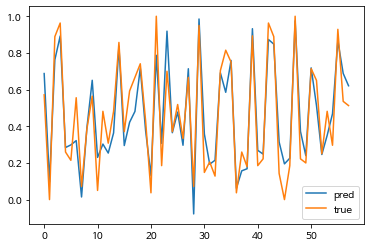

0.09125411262118127


In [271]:
y_pred = model2.predict(X_test)

plt.plot(np.array(y_pred),label = "pred")
plt.plot(np.array(y_test),label = "true")
plt.legend()
plt.show()

print(mean_absolute_error(y_test, y_pred))

단계선택법을 수행하여 변수를 선택한 2차 모델링 결과
mae는 9.12%인 것을 확인할 수 있습니다.

model 1의 mae보다 model 2의 mae가 더 개선되었음을 알 수 있습니다.

## 3.3 Feature간 상관관계

독립변수들 간에 강한 상관관계가 나타나는 다중공선성 문제를 방지하기 위해 변수간 상관관계가 높은 변수들을 제거해야 합니다.


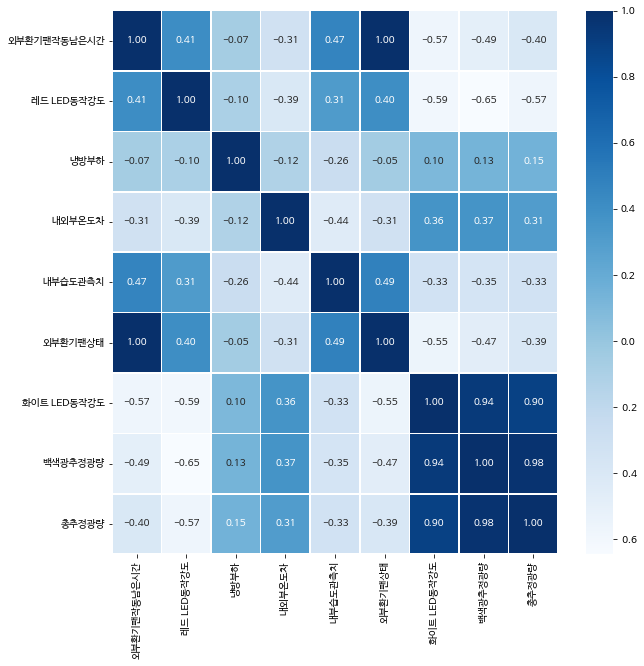

In [272]:
plt.figure(figsize=(10,10))
sns.heatmap(data = step_x.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

일부 feature 간 상관성이 높게 도출되는 것을 확인할 수 있습니다.

일반적으로 OLS회귀나, 여러 회귀와 분류 모형은 변수간 독립성을 가정합니다.  
즉 Feature간 상관관계가 없다는 것을 기본 가정으로 하고 분석이 이루어 진다는 것입니다.


- **VIF(Variance Inflation Factors, 분산팽창요인)**  
다중 회귀 모델에서 독립 변수간 상관 관계가 있는지 측정하는 척도 
VIF가 10이 넘으면 다중공선성이 있다고 판단하며 5가 넘으면 주의할 필요가 있는 것으로 판단  
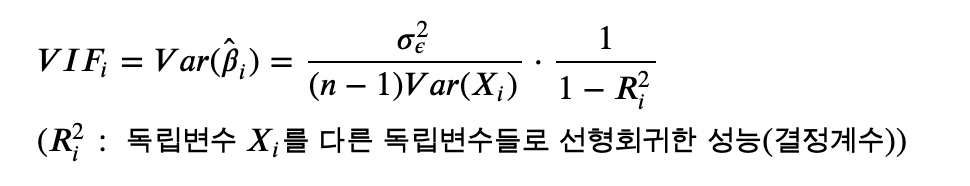


In [273]:
# VIF 출력을 위한 데이터 프레임 형성
vif = pd.DataFrame()

# VIF 값과 각 Feature 이름에 대해 설정
vif["VIF Factor"] = [variance_inflation_factor(step_x.values, i) for i in range(step_x.shape[1])]
vif["features"] = step_x.columns 

# VIF 값이 높은 순으로 정렬
vif = vif.sort_values(by="VIF Factor", ascending=False)
vif = vif.reset_index().drop(columns='index')
vif

,VIF Factor,features
0,259.131954,외부환기팬상태
1,259.062305,외부환기팬작동남은시간
2,215.028420,백색광추정광량
3,140.617159,총추정광량
4,28.632440,화이트 LED동작강도
5,7.399029,내부습도관측치
6,4.542753,내외부온도차
7,3.441188,레드 LED동작강도
8,2.973584,냉방부하


VIF가 10을 초과하는 feature가 5개인 것을 확인할 수 있습니다.  
이런 상황에서 OLS 회귀를 시행한다면, 다중공선성의 문제로 인해 제대로된 결과를 도출하기 어렵습니다.

VIF가 10을 초과하는 feature를 전부 제거하면 정보손실이 크게 발생할 수 있기 때문에 상위의 feature를 하나씩 제거하면서 VIF를 확인했습니다.

In [274]:
def vif(x):
    # vif 10 초과시 drop을 위한 임계값 설정
    thresh = 10
    # Filter method로 feature selection 진행 후 최종 도출 될 데이터 프레임 형성
    output = pd.DataFrame()
    # 데이터의 컬럼 개수 설정
    k = x.shape[1]
    # VIF 측정
    vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    for i in range(1,k):
        print(f'{i}번째 VIF 측정')
        # VIF 최대 값 선정
        a = np.argmax(vif)
        print(f'Max VIF feature & value : {x.columns[a]}, {vif[a]}')
        # VIF 최대 값이 임계치를 넘지 않는 경우 break
        # 임계치 = 10
        if (vif[a] <= thresh):
            print('\n')
            for q in range(output.shape[1]):
                print(f'{output.columns[q]}의 vif는 {np.round(vif[q],2)}입니다.')
            break
        # VIF 최대 값이 임계치를 넘는 경우, + 1번째 시도인 경우 : if 문으로 해당 feature 제거 후 다시 vif 측정
        if (i == 1):
            output = x.drop(x.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        # VIF 최대 값이 임계치를 넘는 경우, + 1번째 이후 시도인 경우 : if 문으로 해당 feature 제거 후 다시 vif 측정
        elif (i > 1):
            output = output.drop(output.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return(output)
    
vif(step_x)

1번째 VIF 측정
Max VIF feature & value : 외부환기팬상태, 259.13195380249175
2번째 VIF 측정
Max VIF feature & value : 화이트 LED동작강도, 214.5387547619473
3번째 VIF 측정
Max VIF feature & value : 외부환기팬상태, 20.316713208128885
4번째 VIF 측정
Max VIF feature & value : 내부습도관측치, 6.0781341245322755


외부환기팬작동남은시간의 vif는 3.49입니다.
레드 LED동작강도의 vif는 2.7입니다.
냉방부하의 vif는 2.9입니다.
내외부온도차의 vif는 3.57입니다.
내부습도관측치의 vif는 6.08입니다.
총추정광량의 vif는 4.4입니다.


,외부환기팬작동남은시간,레드 LED동작강도,냉방부하,내외부온도차,내부습도관측치,총추정광량
0,0.000000,0.870670,0.395318,0.901651,0.076318,0.852921
1,0.000000,0.992256,0.466369,0.975879,0.017478,0.998933
2,0.000000,0.994194,0.420781,0.988041,0.000000,0.998800
3,0.000000,0.994292,0.410280,1.000000,0.043290,0.998091
4,0.000000,0.992870,0.565850,0.975676,0.124564,0.999099
...,...,...,...,...,...,...
281,0.554929,1.000000,0.754086,0.070515,0.977376,0.005035
282,0.628699,0.995728,0.852529,0.418297,0.962087,0.002454
283,0.739412,0.994900,0.230096,0.607974,0.976653,0.001504
284,0.812472,0.993331,0.331628,0.504640,0.973345,0.000108


최종적으로 선별된 feature는 위와 같습니다.

In [275]:
vif_df = df[['외부환기팬작동남은시간', '레드 LED동작강도', '냉방부하', '내외부온도차', '내부습도관측치', '총추정광량','target']]

### Model 3

#### Train & Test 데이터 셋 분리

- vif_y : 예측할 target

- vif_x : 최종적으로 선별된 feature가 포함된 데이터 셋

In [276]:
vif_df.head()

,외부환기팬작동남은시간,레드 LED동작강도,냉방부하,내외부온도차,내부습도관측치,총추정광량,target
0,0.0,0.870670,0.395318,0.901651,0.076318,0.852921,0.000000
1,0.0,0.992256,0.466369,0.975879,0.017478,0.998933,0.025641
2,0.0,0.994194,0.420781,0.988041,0.000000,0.998800,0.051282
3,0.0,0.994292,0.410280,1.000000,0.043290,0.998091,0.076923
4,0.0,0.992870,0.565850,0.975676,0.124564,0.999099,0.102564


In [277]:
vif_y = vif_df['target']
vif_x = vif_df.drop(columns = ['target'])

# train data:test data = 8:2
# 동일 데이터 활용을 위해 random_state=0 고정
X_train, X_test, y_train, y_test = train_test_split(vif_x,vif_y,test_size=0.2,random_state=0)

# 상수항 추가
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(228, 7) (58, 7) (228,) (58,)


#### 모델링

In [278]:
model3 = sm.OLS(y_train, X_train).fit(disp=0)
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     154.7
Date:                Mon, 16 May 2022   Prob (F-statistic):           3.10e-76
Time:                        08:42:51   Log-Likelihood:                 141.48
No. Observations:                 228   AIC:                            -269.0
Df Residuals:                     221   BIC:                            -245.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3987      0.052      7.636      0.000       0.296       0.502
외부환기팬작동남은시간     0.4339      0.032     13.366      0.000       0.370       0.498
레드 LED동작강도      0.1842      0.023      7.971      0.000       0.139       0.230
냉방부하           -0.2423      0.032     -7.638      0.000      -0.305      -0.180
내외부온도차         -0.1678      0.037     -4.587      0.000      -0.240      -0.096
내부습도관측치         0.1242      0.042      2.929      0.004       0.041       0.208
총추정광량          -0.0509      0.027     -1.916      0.057      -0.103       0.001
==============================================================================
Omnibus:                       11.056   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               16.303
Skew:                           0.310   Prob(JB):                     0.000288
Kurtosis:                       4.154   Cond. No.                         13.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- R-squred , Adj.R-squred : 0.808, 0.802  
주어진 데이터를 현재 모형이 얼마나 잘 설명하고 있는지를 나타내는 지수이며, 설명력이 높다고 해석할 수 있습니다.  

- Prob(F-statistics) : 3.10e-76  
현재 모형에 대한 p-value로 보통 0.05인 경우 통계적으로 유의미하다고 판단됩니다.  
따라서 현재 모형은 통계적으로 유의미하다고 볼 수 있습니다.  

- 각 변수들의 p-value  
모든 과정을 거친 변수들은 통계적으로 유의미하다고 볼 수 있습니다.  

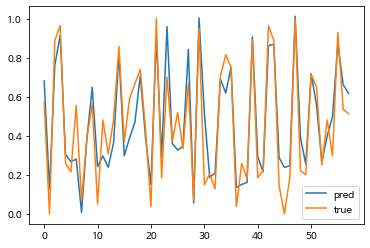

0.09125411262118127


In [279]:
plt.plot(np.array(model3.predict(X_test)),label = "pred")
plt.plot(np.array(y_test),label = "true")
plt.legend()
plt.show()

print(mean_absolute_error(y_test, y_pred))

최종적으로 선별된 변수를 활용한 3차 모델링의 **mae는 9.12%**인 것을 확인할 수 있습니다.  

2차 모델링과 동일한 mae인 것을 알 수 있습니다.
동일한 mae일 경우 더 적은 수의 변수를 활용하여 분석을 진행하는 것이 모델의 부하를 줄일 수 있다고 생각했기 때문에, 
3차 모델링이 가장 유의미한 결과를 도출한다고 판단했습니다.

# 4. 결론

## 4.1 예측 결과

여러 과정을 거쳐 선별된 feature를 활용하여 검증한 결과는 다음과 같습니다.

In [280]:
# 최종 데이터프레임
vif_x

,외부환기팬작동남은시간,레드 LED동작강도,냉방부하,내외부온도차,내부습도관측치,총추정광량
0,0.000000,0.870670,0.395318,0.901651,0.076318,0.852921
1,0.000000,0.992256,0.466369,0.975879,0.017478,0.998933
2,0.000000,0.994194,0.420781,0.988041,0.000000,0.998800
3,0.000000,0.994292,0.410280,1.000000,0.043290,0.998091
4,0.000000,0.992870,0.565850,0.975676,0.124564,0.999099
...,...,...,...,...,...,...
281,0.554929,1.000000,0.754086,0.070515,0.977376,0.005035
282,0.628699,0.995728,0.852529,0.418297,0.962087,0.002454
283,0.739412,0.994900,0.230096,0.607974,0.976653,0.001504
284,0.812472,0.993331,0.331628,0.504640,0.973345,0.000108


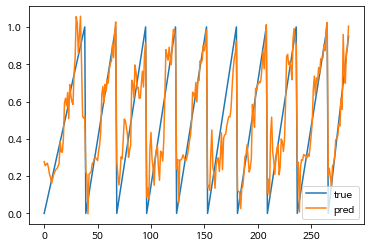

0.09125411262118127


In [281]:
df_pred = model3.predict(sm.add_constant(vif_x))

plt.plot(np.array(vif_y),label = "true")
plt.plot(np.array(df_pred),label = "pred")
plt.legend()
plt.show()

print(mean_absolute_error(y_test, y_pred))

## 4.2 결과 해석

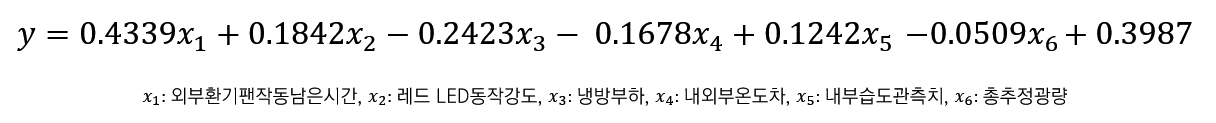

결론적으로 위와 같은 식을 활용하면 적상추의 생육 정도를 정량화할 수 있습니다.